In [1]:
# CPU

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available()) # GPU 사용 가능 여부 확인

2.4.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [4]:
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime
  
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/colab_mnist' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [5]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

print(x_train.shape) # 면, 행, 열(60000개의 흑백이미지)
print(y_train.shape) # 면, 행, 열
print(x_test.shape) # 면, 행, 열
print(y_test.shape) # 면, 행, 열

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
print(x_train[0].shape) # (28, 28), 3차원 배열 첫번째 이미지 산출
print(type(x_train[0]))

(28, 28)
<class 'numpy.ndarray'>


In [7]:
# print(x_train[0])
# 3차원 배열 첫번째 이미지 산출, row: 하나의 행, 2차원에서 하나의 행씩 추출
for row in x_train[0]: 
    for col in row:  # 하나의 행에서 각각의 컬럼 추출
        print('{0:3d}'.format(col), end='')
    print('') # 하나의 행이 출력 완료되면 라인 변경

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  3 18 18 18126136175 26166255247127  0  0  0  0
  0  0  0  0  0  0  0  0 30 36 94154170253253253253253225172253242195 64  0  0  0  0
  0  0  0  0  0  0  0 49238253253253253253253253253251 93 82 82 56 39  0  0  0  0  0
  0  0  0  0  0  0  0 18219253253253253253198182247241  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 80156107253253205 11  0 43154  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 14  1154253 90  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0139253190  2  0  0  0  0  0  0  

class: 5


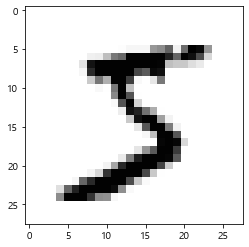

In [8]:
print('class:', y_train[0]) # 첫번째 이미지에 대응하는 레이블(Target, 목표값)
plt.imshow(x_train[0], cmap='Greys') # pixel 배열 -> image
plt.show()

class: 0


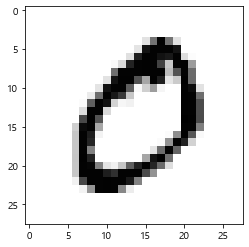

In [9]:
print('class:', y_train[1]) # 첫번째 이미지에 대응하는 레이블(Target, 목표값)
plt.imshow(x_train[1], cmap='Greys') # pixel 배열 -> image
plt.show()

In [10]:
print(x_train.shape)  # (60000, 28, 28)
print('shape[0]:', x_train.shape[0]) # 면, 이미지의 갯수 60,000
print(x_train.shape[1]) # 28 행
print(x_train.shape[2]) # 28 열

(60000, 28, 28)
shape[0]: 60000
28
28


In [11]:
# 차원 변환 과정
# 60,000개의 28x28개 3차원 데이터를 
# 60,000개의 784개 2차원 데이터로 변경
# Dense의 imput_dim은 나열된 숫자를 입력받음으로 차원 변환
# 훈련 데이터 3차원 -> 2차원으로 변형
x_train = x_train.reshape(x_train.shape[0], 784) # 60000행 X 784열
print('x_train:', x_train.shape)
x_train = x_train.astype('float64') # 실수로 변환
x_train = x_train / 255 # 0 ~ 1 정규화, 딥러닝은 실수 처리에 최적화

# 테스트 데이터 3차원 -> 2차원으로 변형
x_test = x_test.reshape(x_test.shape[0], 784).astype('float64') / 255 # 10000 X 784
print('x_test:', x_test.shape)

x_train: (60000, 784)
x_test: (10000, 784)


In [12]:
print(y_train[0:10]) # 실제값, target
print(y_train.shape)

[5 0 4 1 9 2 1 3 1 4]
(60000,)


In [13]:
# one-hot-encoding, 1회만 실행해야함. ★ 
y_train = to_categorical(y_train, 10) # 10: 0 ~ 9까지 10개의 숫자

In [14]:
print(y_train[0:10])
print(y_train.shape)
# [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  5
#  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  0
#  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  4
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]  1
#  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  9
#  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  2
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]  1 
#  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  3
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]  1 
#  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 4

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(60000, 10)


In [15]:
# 1차원 배열을 이용하여 행과 열로 출력
for i in range(50): # 0(중요) ~ 49
    print('행:', i // 5, '열:', i % 5) # 열 index에 대응, //: 몫

행: 0 열: 0
행: 0 열: 1
행: 0 열: 2
행: 0 열: 3
행: 0 열: 4
행: 1 열: 0
행: 1 열: 1
행: 1 열: 2
행: 1 열: 3
행: 1 열: 4
행: 2 열: 0
행: 2 열: 1
행: 2 열: 2
행: 2 열: 3
행: 2 열: 4
행: 3 열: 0
행: 3 열: 1
행: 3 열: 2
행: 3 열: 3
행: 3 열: 4
행: 4 열: 0
행: 4 열: 1
행: 4 열: 2
행: 4 열: 3
행: 4 열: 4
행: 5 열: 0
행: 5 열: 1
행: 5 열: 2
행: 5 열: 3
행: 5 열: 4
행: 6 열: 0
행: 6 열: 1
행: 6 열: 2
행: 6 열: 3
행: 6 열: 4
행: 7 열: 0
행: 7 열: 1
행: 7 열: 2
행: 7 열: 3
행: 7 열: 4
행: 8 열: 0
행: 8 열: 1
행: 8 열: 2
행: 8 열: 3
행: 8 열: 4
행: 9 열: 0
행: 9 열: 1
행: 9 열: 2
행: 9 열: 3
행: 9 열: 4
